# Rayleigh-Marchenko imaging with angle gathers

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import time
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.io import loadmat

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

from pymarchenko.raymarchenko import RayleighMarchenko
from pymarchenko.anglegather import AngleGather

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

## Inputs

Input parameters 

In [3]:
inputfile = '../data/raymarchenko/input_dualsensor.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
tsoff = 0.06        # direct arrival time shift source side
troff = 0.06        # direct arrival time shift receiver side
nsmooth = 10        # time window smoothing 
nfmax = 550         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 30         # iterations
kt = 120            # portion of time axis to remove
convolvedata = False # Apply convolution to data

jr = 1              # subsampling in r
js = 1              # subsampling in s
jt = 1              # subsampling for MDD

igaths = [1, 8, 
          16, 24, 
          32]       # indeces of Angle gathers
nalpha = 41         # number of angles in Angle gathers
plotflag = False

ngath = len(igaths)

Load input

In [4]:
inputdata = np.load(inputfile)

Read and visualize geometry

In [5]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

Read data

In [6]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# data
#p = inputdata['p'][::js, :, ::jr]
#vz = inputdata['vz'][::js, :, ::jr]

# separated data
d = loadmat('../data/raymarchenko/separated_data.mat')
Vzu = d['VUP'][:,:,::js]
Vzd = d['VDOWN'][:,:,::js]

In [7]:
# remove early time
Vzu = Vzu[kt:]
Vzd = Vzd[kt:]
t = t[:-kt]
nt = len(t)

In [8]:
wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt)
wav_c = np.argmax(wav)

Convolve data with wavelet (optional)

In [9]:
if convolvedata:
    Vzu = dt * np.apply_along_axis(convolve, 0, Vzu, wav, mode='full')
    Vzu = Vzu[wav_c:][:nt]
    Vzd = dt * np.apply_along_axis(convolve, 0, Vzd, wav, mode='full')
    Vzd = Vzd[wav_c:][:nt]

In [10]:
# move receivers to integration axis
Vzu = Vzu.transpose(2, 1, 0) # R[s, r, t]
Vzd = Vzd.transpose(2, 1, 0) # R[s, r, t]

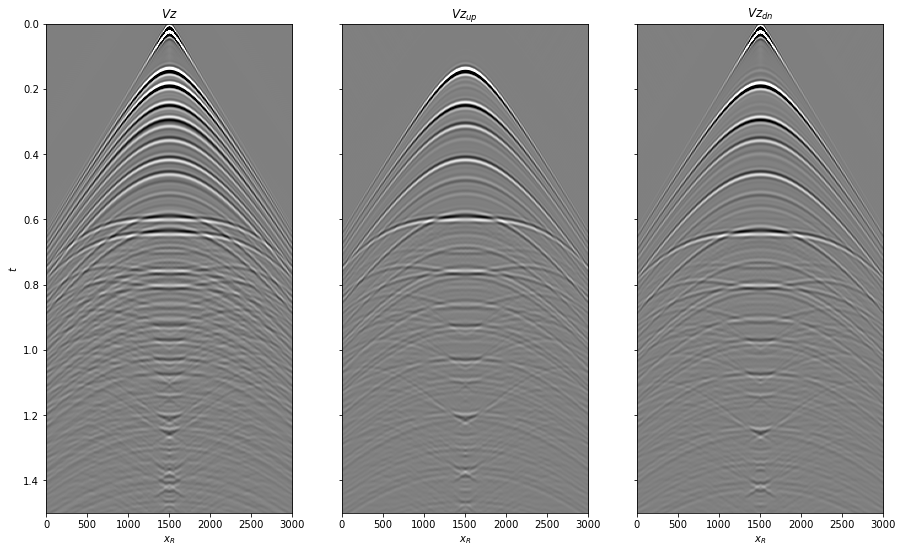

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(Vzu[ns//2].T+Vzd[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Vz$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(Vzu[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Vz_{up}$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(Vzd[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$Vz_{dn}$'), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

Define imaging domain

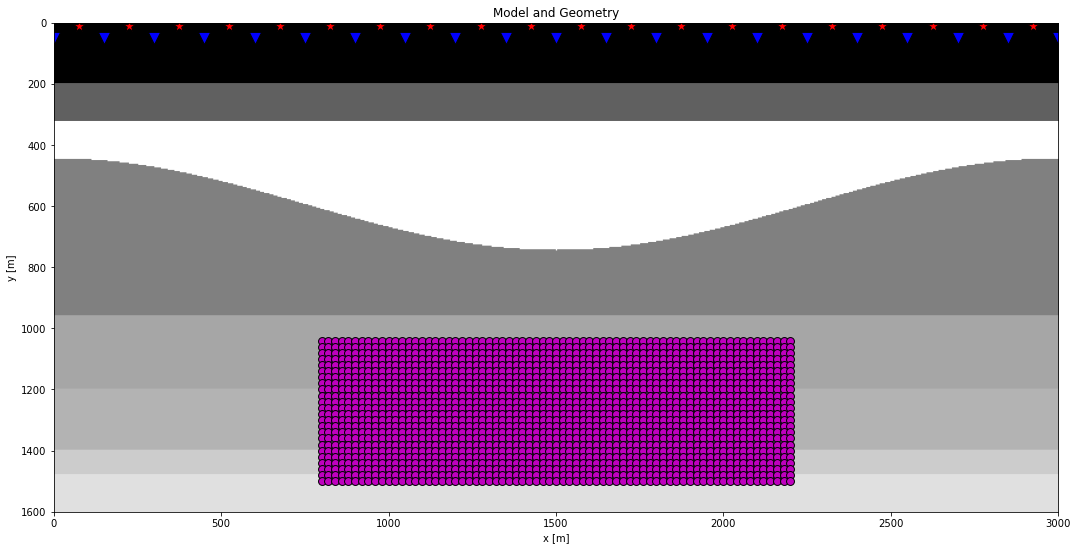

In [12]:
#nvsx, nvsz = 81, 1
#dvsx, dvsz = 20, 10
#vsx = np.arange(nvsx)*dvsx + 700
#vsz = np.arange(nvsz)*dvsz + 850

#nvsx, nvsz = 81, 6
#dvsx, dvsz = 20, 10
#vsx = np.arange(nvsx)*dvsx + 700
#vsz = np.arange(nvsz)*dvsz + 850

nvsx, nvsz = 71, 24
dvsx, dvsz = 20, 20
vsx = np.arange(nvsx)*dvsx + 800
vsz = np.arange(nvsz)*dvsz + 1040

VSX, VSZ = np.meshgrid(vsx, vsz, indexing='ij')

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(VSX.ravel(), VSZ.ravel(), marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Perform imaging for the different depth levels

In [13]:
def imaging_depth_level(ivsz, nvsz, vsx, vsz, r, nr, dr, nt, dt, vel, troff, tsoff, nsmooth, wav, Vzd, Vzu):
    print('Working on %d/%d' % (ivsz, nvsz))
    # direct arrival window - traveltime
    directVSr = np.sqrt((vsx-r[0][:, np.newaxis])**2+(vsz[ivsz]-r[1][:, np.newaxis])**2)/vel
    directVSr_off = directVSr - troff
    directVSs = np.sqrt((vsx-s[0][:, np.newaxis])**2+(vsz[ivsz]-s[1][:, np.newaxis])**2)/vel
    directVSs_off = directVSs - tsoff

    # window
    idirectVSr_off = np.round(directVSr_off/dt).astype(np.int)
    idirectVSs_off = np.round(directVSs_off/dt).astype(np.int)
    
    wr = np.zeros((nr, nvsx, nt))
    ws = np.zeros((ns, nvsx, nt))
    for ir in range(nr):
        for ivs in range(nvsx):
            wr[ir, ivs, :idirectVSr_off[ir, ivs]]=1
    for ir in range(ns):    
        for ivs in range(nvsx):
            ws[ir, ivs, :idirectVSs_off[ir, ivs]]=1
    wr = np.hstack((np.fliplr(wr), wr[:, 1:]))
    ws = np.hstack((np.fliplr(ws), ws[:, 1:]))

    if nsmooth>0:
        smooth=np.ones(nsmooth)/nsmooth
        wr  = filtfilt(smooth, 1, wr)
        ws  = filtfilt(smooth, 1, ws)
       
    G0sub_rec = np.zeros((nr, nvsx, nt))
    for ivs in range(nvsx):
        G0sub_rec[:, ivs] = directwave(wav, directVSr[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T
    
    G0sub_src = np.zeros((ns, nvsx, nt))
    for ivs in range(nvsx):
        G0sub_src[:, ivs] = directwave(wav, directVSs[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T
        
    rm = RayleighMarchenko(Vzd, Vzu, dt=dt, dr=dr,
                           nfmax=nfmax, wav=wav, toff=troff, nsmooth=nsmooth,
                           saveVt=True, prescaled=False)
    f1_inv_minus, f1_inv_plus, p0_minus, g_inv_minus, g_inv_plus = \
        rm.apply_multiplepoints(directVSs, directVSr, G0=G0sub_rec, rtm=True, greens=True, 
                                dottest=False, **dict(iter_lim=n_iter, show=False))
    print('Done Mck %d/%d' % (ivsz, nvsz))

    
    # MDD
    _, Rrtm = MDD(G0sub_src[:, :, ::jt], p0_minus[:, :, nt-1:][:, :, ::jt], 
                  dt=jt*dt, dr=dvsx, twosided=True, adjoint=True, psf=False, wav=wav[wav_c-60:wav_c+60],
                  nfmax=nfmax, dtype='complex64', dottest=False, **dict(iter_lim=0, show=0))
 
    Rmck = MDD(g_inv_plus[:, :, nt-1:][:, :, ::jt], g_inv_minus[:, :, nt-1:][:, :, ::jt], 
               dt=jt*dt, dr=dvsx, twosided=True, adjoint=False, psf=False, wav=wav[wav_c-60:wav_c+60],
               nfmax=nfmax, dtype='complex64', dottest=False, **dict(iter_lim=10, show=0))
    print('Done MDD %d/%d' % (ivsz, nvsz))
    
    # Images
    irtm = np.diag(Rrtm[:, :, nt-1])
    imck = np.diag(Rmck[:, :, nt-1])
    
    # Angle gathers
    artm = np.zeros((ngath, nalpha))
    amck = np.zeros((ngath, nalpha))
    for i, igath in enumerate(igaths):
        artm[i], angle, Ra = AngleGather(Rrtm.transpose(2, 0, 1), nvsx, nalpha, 
                                         dt*jt, dvsx, igath, vel, plotflag=plotflag)
        amck[i], angle, Ra = AngleGather(Rmck.transpose(2, 0, 1), nvsx, nalpha, 
                                         dt*jt, dvsx, igath, vel, plotflag=plotflag)
    print('Done %d/%d' % (ivsz, nvsz))
    return irtm, imck, artm, amck

In [14]:
#imaging_depth_level(10, nvsz, vsx, vsz, r, nr, dr, nt, dt, vel, troff, tsoff, nsmooth, wav, Vzd, Vzu)

In [15]:
t0 = time.time()
results = [imaging_depth_level(ivsz, nvsz, vsx, vsz, r, nr, dr, 
                               nt, dt, vel, troff, tsoff, nsmooth, wav, Vzd, Vzu) for ivsz in range(nvsz)]
print('Elapsed time (mins): ', (time.time()- t0) / 60.)

Working on 0/24
Done Mck 0/24
Done MDD 0/24
Done 0/24
Working on 1/24
Done Mck 1/24
Done MDD 1/24
Done 1/24
Working on 2/24
Done Mck 2/24
Done MDD 2/24
Done 2/24
Working on 3/24
Done Mck 3/24
Done MDD 3/24
Done 3/24
Working on 4/24
Done Mck 4/24
Done MDD 4/24
Done 4/24
Working on 5/24
Done Mck 5/24
Done MDD 5/24
Done 5/24
Working on 6/24
Done Mck 6/24
Done MDD 6/24
Done 6/24
Working on 7/24
Done Mck 7/24
Done MDD 7/24
Done 7/24
Working on 8/24
Done Mck 8/24
Done MDD 8/24
Done 8/24
Working on 9/24
Done Mck 9/24
Done MDD 9/24
Done 9/24
Working on 10/24
Done Mck 10/24
Done MDD 10/24
Done 10/24
Working on 11/24
Done Mck 11/24
Done MDD 11/24
Done 11/24
Working on 12/24
Done Mck 12/24
Done MDD 12/24
Done 12/24
Working on 13/24
Done Mck 13/24
Done MDD 13/24
Done 13/24
Working on 14/24
Done Mck 14/24
Done MDD 14/24
Done 14/24
Working on 15/24
Done Mck 15/24
Done MDD 15/24
Done 15/24
Working on 16/24
Done Mck 16/24
Done MDD 16/24
Done 16/24
Working on 17/24
Done Mck 17/24
Done MDD 17/24
Done 17

In [16]:
irtm = np.vstack([results[ivsz][0] for ivsz in range(nvsz)])
imck = np.vstack([results[ivsz][1] for ivsz in range(nvsz)])
artm = np.concatenate([results[ivsz][2][:, np.newaxis, :] for ivsz in range(nvsz)], axis=1)
amck = np.concatenate([results[ivsz][3][:, np.newaxis, :] for ivsz in range(nvsz)], axis=1)

Visualize the stardard single-scattering (eg RTM) image and the Marchenko image

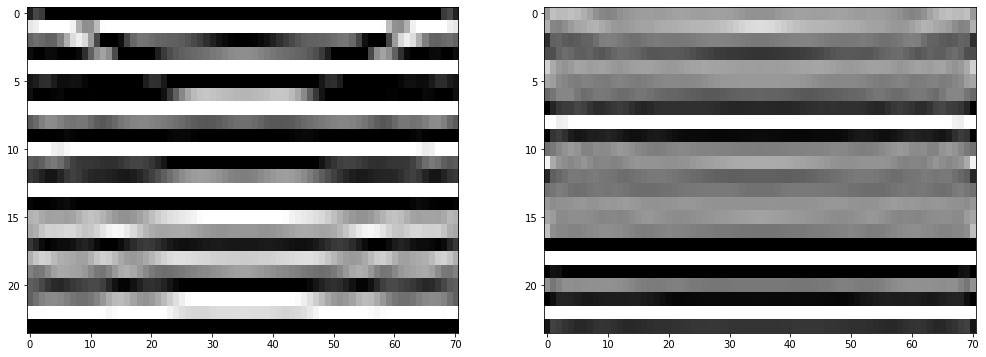

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(irtm, cmap='gray', vmin=-1e6, vmax=1e6,)
axs[0].axis('tight')
axs[1].imshow(imck, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight');

And the same for angle gathers

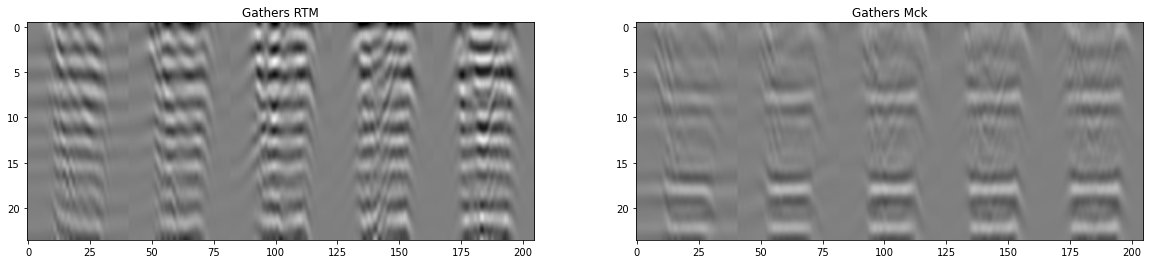

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
axs[0].imshow(artm.transpose(0, 2, 1).reshape(ngath*nalpha, nvsz).T, cmap='gray', vmin=-1e10, vmax=1e10,
              interpolation='sinc')
axs[0].axis('tight')
axs[0].set_title('Gathers RTM')
axs[1].imshow(amck.transpose(0, 2, 1).reshape(ngath*nalpha, nvsz).T, cmap='gray', vmin=-1e3, vmax=1e3,
              interpolation='sinc')
axs[1].set_title('Gathers Mck')
axs[1].axis('tight');